### **Import Dependencies**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError

## **Import Data**

In [22]:
data_path = '/content/DIS.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [23]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-26,94.449997,95.000000,93.930000,94.970001,88.513306,5446900
2015-01-27,93.940002,94.739998,93.360001,93.970001,87.581306,5390000
2015-01-28,94.139999,94.470001,92.610001,92.669998,86.369682,6198400
2015-01-29,93.110001,93.500000,91.519997,93.220001,86.882286,7681700
2015-01-30,92.500000,92.940002,90.830002,90.959999,84.775940,10212300
...,...,...,...,...,...,...
2023-08-18,85.370003,86.720001,85.370003,85.959999,85.959999,12353900
2023-08-21,85.809998,86.250000,85.410004,85.879997,85.879997,11215000
2023-08-22,85.709999,86.089996,85.370003,85.790001,85.790001,9845900


In [24]:
data.reset_index(inplace=True)
data = data[['Date', 'Close']]
data

,Date,Close
0,2015-01-26,94.970001
1,2015-01-27,93.970001
2,2015-01-28,92.669998
3,2015-01-29,93.220001
4,2015-01-30,90.959999
...,...,...
2156,2023-08-18,85.959999
2157,2023-08-21,85.879997
2158,2023-08-22,85.790001
2159,2023-08-23,85.830002


## **Prepare Data**

In [25]:
scaler = MinMaxScaler()
data['Close_scaled'] = scaler.fit_transform(data[['Close']])

<ipython-input-25-c6e4246e590d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close_scaled'] = scaler.fit_transform(data[['Close']])


In [26]:
data

,Date,Close,Close_scaled
0,2015-01-26,94.970001,0.104655
1,2015-01-27,93.970001,0.096283
2,2015-01-28,92.669998,0.085398
3,2015-01-29,93.220001,0.090003
4,2015-01-30,90.959999,0.071082
...,...,...,...
2156,2023-08-18,85.959999,0.029220
2157,2023-08-21,85.879997,0.028550
2158,2023-08-22,85.790001,0.027796
2159,2023-08-23,85.830002,0.028131


## **Define The steps**

In [27]:
time_steps = 30  # Adjust as needed

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data['Close_scaled'][i:i+time_steps])
    y.append(data['Close_scaled'][i+time_steps])

X = np.array(X)
y = np.array(y)

## **Train-Test Split**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## **Build LSTM model**

In [29]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError()])

## **Train the model**

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
54/54 [==============================] - 12s 112ms/step - loss: 0.0164 - mean_absolute_error: 0.0773 - val_loss: 0.0033 - val_mean_absolute_error: 0.0442
Epoch 2/100
54/54 [==============================] - 2s 44ms/step - loss: 0.0016 - mean_absolute_error: 0.0278 - val_loss: 0.0025 - val_mean_absolute_error: 0.0392
Epoch 3/100
54/54 [==============================] - 3s 53ms/step - loss: 0.0014 - mean_absolute_error: 0.0253 - val_loss: 0.0022 - val_mean_absolute_error: 0.0373
Epoch 4/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0013 - mean_absolute_error: 0.0240 - val_loss: 0.0022 - val_mean_absolute_error: 0.0372
Epoch 5/100
54/54 [==============================] - 5s 85ms/step - loss: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.0018 - val_mean_absolute_error: 0.0345
Epoch 6/100
54/54 [==============================] - 4s 76ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - val_loss: 0.0017 - val_mean_absolute_error: 0.0333
Epoch 7/100
54

## **Predictions**

In [31]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

14/14 [==============================] - 0s 13ms/step


## **Inverse transform predictions**

In [33]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0]
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

## **Plotting**

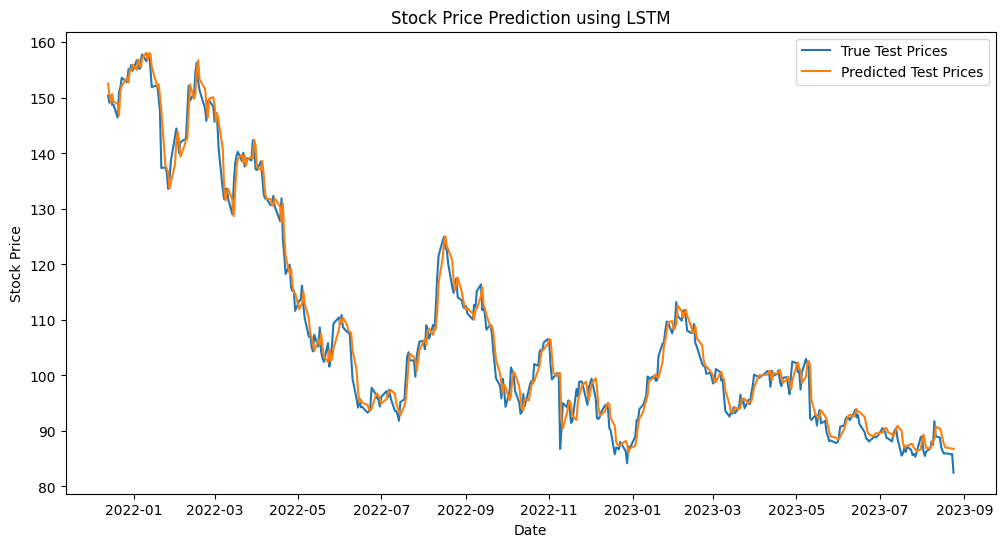

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(data['Date'][-len(y_test):], y_test, label='True Test Prices')
plt.plot(data['Date'][-len(y_test):], test_predictions, label='Predicted Test Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()